In [76]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jan 25 17:11:08 2019

@author: mgelman
"""
#fafe
import csv
import itertools
import operator
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import graphviz
from scipy.sparse import hstack
from sklearn import tree
import pydot
import pydotplus
from sklearn.externals.six import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [77]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Loading In Data

In [78]:
# import data
path = os.path.join(os.path.expanduser("~"), "Documents", "lowe_house_price_prediction", "yelp_dataset")
#sys.path.insert(0, path)
#sys.path.insert(0, "C:\Users\mgelman\AppData\Local\Continuum\anaconda2\Library\bin\graphviz")

# LOAD BUSINESS DATA
inputfile = os.path.join(path, "business.json")
business_data = pd.read_json(inputfile, lines=True)
# keep a subset of variables
business_data = business_data[['business_id', 'postal_code', 'state', 'categories']]
# trim the category text
business_data['categories'] = business_data['categories'].str.slice(stop=50)
business_data['categories'] = business_data['categories'].str.encode('ascii', errors='coerce')
#business_data['categories'] = business_data['categories'].str.replace('&', '')

# convert postal code to integers (will get rid of non-us zipcodes)
business_data['postal_code'] = pd.to_numeric(business_data['postal_code'], errors='coerce')
business_data.dropna(inplace=True)

In [79]:
business_data.head(100)

,business_id,postal_code,state,categories
0,1SWheh84yJXfytovILXOAQ,85016.0,AZ,"b'Golf, Active Life'"
2,gnKjwL_1w79qoiV3IC_xQQ,28210.0,NC,"b'Sushi Bars, Restaurants, Japanese'"
3,xvX2CttrVhyG2z1dFg_0xw,85338.0,AZ,"b'Insurance, Financial Services'"
4,HhyxOkGAM07SRYtlQ4wMFQ,28217.0,NC,"b'Plumbing, Shopping, Local Services, Home Ser..."
7,gbQN7vr_caG_A1ugSmGhWg,89121.0,NV,"b""Hair Salons, Hair Stylists, Barbers, Men's H..."
...,...,...,...,...
130,DwsESfIDIsgQ4DTx9VNOsw,85016.0,AZ,"b'Home Services, Handyman, Painters, Contractors'"
131,faixHjogPjNUo07T0RBRFw,89118.0,NV,"b'Security Systems, Home Services'"
132,3aUBEB206LBNLUY6rCW2sw,85282.0,AZ,"b'Traditional Chinese Medicine, Health & Medic..."
133,ysfeDcLAYk_MVzfBmyiSTg,85007.0,AZ,"b'Restaurants, Food, Cafes'"


In [80]:
# LOAD IN REVIEW DATA (use unix command top to create a smaller version of the dataset)
# head -n NUMBEROFLINES file.json > mynewfile.json
# TO GET SPECIFIC YEAR
# grep -E '201[0|1|2]' review.json > review_2010-2012.json
# inputfile=os.path.join(path,"review.json")
inputfile = os.path.join(path, "review_10k.json")
outputfile = os.path.join(path, "review.pkl")
review_data = pd.read_json(inputfile, lines=True)
# only keep business_id, date, stars, text
review_data = review_data[['business_id', 'date', 'stars', 'text']]
# take out numbers in 'text'
review_data['text'] = review_data['text'].str.replace('[0-9]', '')


In [81]:
vectorizer = TfidfVectorizer(ngram_range=(1, 1),
                            stop_words='english',
                            min_df=30)
X_test= vectorizer.fit_transform(review_data['text'])
names=vectorizer.get_feature_names()

In [82]:
inputfile = os.path.join(path, "Zip_Zhvi_AllHomes.csv")
# zillow_data = pd.read_csv(inputfile, header=0, quoting=3)
zillow_data = pd.read_csv(inputfile, encoding='latin-1')

In [83]:
zillow_data.head(100)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09
0,61639,10025,New York,NY,New York-Newark-Jersey City,New York County,1,168300.0,168400.0,168400.0,...,1054100,1032200,1019300,1014500,995100,978700,973800,975700,975700,973300
1,84654,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,2,160000.0,161000.0,161700.0,...,353500,353500,354500,354300,352300,349700,347800,347200,346000,344500
2,61637,10023,New York,NY,New York-Newark-Jersey City,New York County,3,353100.0,353700.0,354200.0,...,1380000,1375600,1376300,1369800,1364200,1375100,1403700,1413700,1415100,1422300
3,91982,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,4,210400.0,212200.0,212200.0,...,335700,335100,334100,333500,333500,333400,331900,329600,327700,326700
4,84616,60614,Chicago,IL,Chicago-Naperville-Elgin,Cook County,5,194400.0,196100.0,197300.0,...,432600,433100,433800,432800,430700,428600,426000,423000,419900,419200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,79054,48197,Ypsilanti,MI,Ann Arbor,Washtenaw County,96,126900.0,127600.0,128400.0,...,222500,225000,227500,228300,228800,229300,229600,230000,230500,230900
96,77007,44107,Lakewood,OH,Cleveland-Elyria,Cuyahoga County,97,93700.0,94100.0,94500.0,...,188300,190100,192300,192400,189000,186400,187500,189300,190500,191800
97,87074,66062,Olathe,KS,Kansas City,Johnson County,98,107200.0,107400.0,107800.0,...,261300,262600,264200,265600,266400,266600,267000,267300,268300,269600
98,62022,11211,New York,NY,New York-Newark-Jersey City,Kings County,99,146000.0,146300.0,146500.0,...,961700,964600,969800,972700,974300,975900,977700,981100,982900,979800


# Data Wrangling on the Zillow Data

In [84]:
# Drop some columns
zillow_data.drop(['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], axis=1, inplace=True)
# Make it such that: RegionName is the only identifier, the others are variable year then then value 
zillow_data = pd.melt(zillow_data, id_vars='RegionName', value_vars=list(zillow_data.columns.values)[1:])

In [85]:
zillow_data.head(100)

,RegionName,variable,value
0,10025,1996-04,168300.0
1,60657,1996-04,160000.0
2,10023,1996-04,353100.0
3,77494,1996-04,210400.0
4,60614,1996-04,194400.0
...,...,...,...
95,48197,1996-04,126900.0
96,44107,1996-04,93700.0
97,66062,1996-04,107200.0
98,11211,1996-04,146000.0


In [86]:
# generate datetime
zillow_data['date'] = pd.to_datetime(zillow_data['variable'])
zillow_data['year'] = zillow_data['date'].dt.year

In [87]:
zillow_data.head(10)

,RegionName,variable,value,date,year
0,10025,1996-04,168300.0,1996-04-01,1996
1,60657,1996-04,160000.0,1996-04-01,1996
2,10023,1996-04,353100.0,1996-04-01,1996
3,77494,1996-04,210400.0,1996-04-01,1996
4,60614,1996-04,194400.0,1996-04-01,1996
5,77449,1996-04,95400.0,1996-04-01,1996
6,10002,1996-04,NaN,1996-04-01,1996
7,77084,1996-04,94700.0,1996-04-01,1996
8,79936,1996-04,77200.0,1996-04-01,1996
9,60640,1996-04,99400.0,1996-04-01,1996


In [88]:
# get yearly mean
zillow_yearly_avg = zillow_data.groupby(['RegionName', 'year'])['value'].mean().reset_index()

In [89]:
zillow_yearly_avg.head(10)

,RegionName,year,value
0,1001,1996,104900.000000
1,1001,1997,107283.333333
2,1001,1998,111050.000000
3,1001,1999,114000.000000
4,1001,2000,120416.666667
5,1001,2001,129525.000000
6,1001,2002,140400.000000
7,1001,2003,153458.333333
8,1001,2004,171991.666667
9,1001,2005,197291.666667


# Merge Yelp and Zillow Data

In [90]:
# %% Merge everyting together

# First merge the yelp data to get zipcode
yelp_merged = review_data.merge(business_data, left_on='business_id', right_on='business_id', how='left',
                                validate="m:1")
yelp_merged['year'] = pd.to_datetime(yelp_merged['date']).dt.year

In [91]:
# At this point, each row of the yelp data still just corresponds to a single review  
yelp_merged.head(10)

,business_id,date,stars,text,postal_code,state,categories,year
0,ujmEBvifdJM6h6RLv4wQIg,2013-05-07 04:34:36,1,Total bill for this horrible service? Over $Gs...,89128.0,NV,"b'Fitness & Instruction, Doctors, Health & Med...",2013
1,NZnhc2sEQy3RmzKTZnqtwQ,2017-01-14 21:30:33,5,I *adore* Travis at the Hard Rock's new Kelly ...,89169.0,NV,"b'Beauty & Spas, Hair Stylists, Makeup Artists...",2017
2,WTqjgwHlXbSFevF32_DJVw,2016-11-09 20:09:03,5,I have to say that this office really has it t...,85286.0,AZ,"b'Health & Medical, Cosmetic Dentists, Orthodo...",2016
3,ikCg8xy5JIg_NGPx-MSIDA,2018-01-09 20:56:38,5,Went in for a lunch. Steak sandwich was delici...,NaN,NaN,NaN,2018
4,b1b1eb3uo-w561D0ZfCEiQ,2018-01-30 23:07:38,1,Today was my second out of three sessions I ha...,85251.0,AZ,"b'Teeth Whitening, Beauty & Spas'",2018
5,eU_713ec6fTGNO4BegRaww,2013-01-20 13:25:59,4,I'll be the first to admit that I was not exci...,15211.0,PA,"b'Restaurants, Italian, Pizza'",2013
6,3fw2X5bZYeW9xCz_zGhOHg,2016-05-07 01:21:02,3,Tracy dessert had a big name in Hong Kong and ...,NaN,NaN,NaN,2016
7,zvO-PJCpNk4fgAVUnExYAA,2010-10-05 19:12:35,1,This place has gone down hill. Clearly they h...,85254.0,AZ,"b'Sports Bars, Bars, Restaurants, American (Ne...",2010
8,b2jN2mm9Wf3RcrZCgfo1cg,2015-01-18 14:04:18,2,I was really looking forward to visiting after...,44113.0,OH,"b'Breweries, Event Planning & Services, Pubs, ...",2015
9,oxwGyA17NL6c5t1Etg5WgQ,2012-02-29 21:52:43,3,It's a giant Best Buy with registers. I don'...,89119.0,NV,"b'Shopping, Computers, Electronics, Mobile Pho...",2012


In [92]:
# merge current yelp with zillow based on postal code and year 
final_data = yelp_merged.merge(zillow_yearly_avg, left_on=['postal_code', 'year'], right_on=['RegionName', 'year'],
                               how='left', validate="m:1")
final_data.dropna(inplace=True)

#csv_file_name = os.path.join(path, "yelp_zillow.tsv")
#final_data[['year', 'stars', 'postal_code', 'state', 'value']].to_csv(csv_file_name, sep='\t', encoding='utf-8',
#                                                                      index=False, quoting=csv.QUOTE_NONE)

In [93]:
# Again, current merged data, at this point, has every row map to a distinct review text. The value column is the average housing price of that year  
final_data.head(10)

,business_id,date,stars,text,postal_code,state,categories,year,RegionName,value
0,ujmEBvifdJM6h6RLv4wQIg,2013-05-07 04:34:36,1,Total bill for this horrible service? Over $Gs...,89128.0,NV,"b'Fitness & Instruction, Doctors, Health & Med...",2013,89128.0,143991.666667
1,NZnhc2sEQy3RmzKTZnqtwQ,2017-01-14 21:30:33,5,I *adore* Travis at the Hard Rock's new Kelly ...,89169.0,NV,"b'Beauty & Spas, Hair Stylists, Makeup Artists...",2017,89169.0,152050.000000
2,WTqjgwHlXbSFevF32_DJVw,2016-11-09 20:09:03,5,I have to say that this office really has it t...,85286.0,AZ,"b'Health & Medical, Cosmetic Dentists, Orthodo...",2016,85286.0,327025.000000
4,b1b1eb3uo-w561D0ZfCEiQ,2018-01-30 23:07:38,1,Today was my second out of three sessions I ha...,85251.0,AZ,"b'Teeth Whitening, Beauty & Spas'",2018,85251.0,324441.666667
5,eU_713ec6fTGNO4BegRaww,2013-01-20 13:25:59,4,I'll be the first to admit that I was not exci...,15211.0,PA,"b'Restaurants, Italian, Pizza'",2013,15211.0,68616.666667
7,zvO-PJCpNk4fgAVUnExYAA,2010-10-05 19:12:35,1,This place has gone down hill. Clearly they h...,85254.0,AZ,"b'Sports Bars, Bars, Restaurants, American (Ne...",2010,85254.0,291175.000000
11,mRUVMJkUGxrByzMQ2MuOpA,2017-12-15 23:27:08,1,"Walked in around on a Friday afternoon, we sa...",85209.0,AZ,"b'Restaurants, Breakfast & Brunch, Burgers, Am...",2017,85209.0,239233.333333
12,FxLfqxdYPA6Z85PFKaqLrg,2016-05-07 01:36:53,4,Wow. So surprised at the one and two star revi...,15241.0,PA,"b'Italian, Salad, Restaurants, Gluten-Free'",2016,15241.0,273908.333333
13,LUN6swQYa4xJKaM_UEUOEw,2018-04-27 20:25:26,4,Michael from Red Carpet VIP is amazing ! I rea...,89109.0,NV,"b'Hotels & Travel, Travel Services, Nightlife,...",2018,89109.0,328966.666667
16,NyLYY8q1-H3hfsTwuwLPCg,2015-01-03 22:47:34,4,Great lunch today. Staff was very helpful in a...,44122.0,OH,"b'Fast Food, Vegetarian, Restaurants, Vegan, I...",2015,44122.0,203458.333333


# Aggregate

In [94]:
# First aggregate to zip year
# create the dictionary for the collapse (mapping from var to agg type)

# group by creates a mapping from the user_id to the row index. Ie, user 1 maps to rows 4,5,6, user 2 maps to rows 7,8,9.
data_group = final_data.groupby(['postal_code', 'year'], as_index=False)

In [95]:
# aggregate in groups depending on the var type
# group 1: numerical variables
mean = ['value', 'stars']

# group 2: retain all strings
all = ['text']

# group 3: ID vars: like state
first = ['state']

# create the dictionary for the collapse (mapping from var to agg type)
d = {}
d_agg_type = {'first': first,
              np.nanmean: mean,
              lambda x: " ".join(x): all}

In [96]:
d_agg_type.items()

dict_items([('first', ['state']), (<function nanmean at 0x10c854598>, ['value', 'stars']), (<function <lambda> at 0x1a32f2bf28>, ['text'])])

In [97]:
#key is the function, value is the column names 
for key, value in d_agg_type.items():
    for col in value:
        d.update({col: key})

In [98]:
#specify the way of aggregartion per column
d

{'state': 'first',
 'value': <function numpy.nanmean(a, axis=None, dtype=None, out=None, keepdims=<no value>)>,
 'stars': <function numpy.nanmean(a, axis=None, dtype=None, out=None, keepdims=<no value>)>,
 'text': <function __main__.<lambda>(x)>}

In [99]:
# collapse data
final_data_collapsed = data_group.agg(d)

In [100]:
#at this point, each row is distinct by postal_code and year, the value is the average house price, stars is the average stars, and text is all the reviews combined 
final_data_collapsed.head(10)

,postal_code,year,state,value,stars,text
0,15003.0,2018,PA,79450.000000,5.00,Best place to get ice cream. They have only tw...
1,15017.0,2013,PA,132300.000000,4.00,Very good burgers and fries. The bun was just...
2,15017.0,2014,PA,138266.666667,3.50,Came here on a date night with my girlfriend ...
3,15017.0,2016,PA,152375.000000,4.00,I have NEVER had a bad meal there! Larissa has...
4,15017.0,2017,PA,162141.666667,3.50,It was hard to decide one star or two. The foo...
5,15017.0,2018,PA,170575.000000,2.75,I was sent to Vision Source South Hills for a ...
6,15037.0,2013,PA,90425.000000,3.00,My friend and I went to Becky's Place for a la...
7,15044.0,2014,PA,222275.000000,4.00,This Goodwill is an absolute gem for women's c...
8,15044.0,2016,PA,245650.000000,2.00,I want to start by saying that the staff there...
9,15045.0,2016,PA,33233.333333,1.00,Sounds like things haven't changed. Bad servic...


# Calculate Changes 

In [101]:
# create log prices
final_data_collapsed['log_price'] = np.log(final_data_collapsed['value'])

# NEED TO SORT TO GET DIFF
final_data_collapsed.sort_values(['postal_code', 'year'], inplace=True)

# convert words to word differences
vectorizer = TfidfVectorizer(ngram_range=(1, 1),
                             stop_words='english',
                             min_df=30)
X_test = vectorizer.fit_transform(final_data_collapsed['text'])

In [102]:
# add the zipcode and year to the words
word_df = pd.concat([final_data_collapsed[['postal_code', 'year']], pd.DataFrame(X_test.todense())], axis=1)

In [103]:
# word_df is a feature vector of reviews + corresponding postal_code and year 
word_df.head(10)

,postal_code,year,0,1,2,3,4,5,6,7,...,1612,1613,1614,1615,1616,1617,1618,1619,1620,1621
0,15003.0,2018,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,15017.0,2013,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,15017.0,2014,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,15017.0,2016,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0703,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,15017.0,2017,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
5,15017.0,2018,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.136873,...,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
6,15037.0,2013,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0000,0.0,0.0,0.129917,0.0,0.0,0.0,0.0
7,15044.0,2014,0.0,0.292396,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
8,15044.0,2016,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
9,15045.0,2016,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [104]:
# take the difference within rows with the same postal_code 
word_df = word_df.groupby(['postal_code']).diff()

In [105]:
# Each row taking a difference to the row before. NaN happens when previous row doesn't exist or doesn't have the same postal code  
word_df.head(10)

,year,0,1,2,3,4,5,6,7,8,...,1612,1613,1614,1615,1616,1617,1618,1619,1620,1621
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0703,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,-0.0703,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.136873,0.0,...,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2.0,0.0,-0.292396,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
# only keep one year difference
word_df = word_df.loc[word_df['year'] == 1]
# drop the column and covert back to sparse matrix
word_df.drop(['year'], axis=1, inplace=True)
X_words = scipy.sparse.csr_matrix(word_df.values)

In [107]:
#the review df only has rows that were about 1 year difference in its own group
word_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,1612,1613,1614,1615,1616,1617,1618,1619,1620,1621
2,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,-0.070300,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
5,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.136873,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
15,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
19,0.0,0.0,0.000000,0.0,0.0,-0.059678,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.085080,0.053121,0.0,0.0,0.064866,0.0,0.0,0.0
20,0.0,0.0,0.128381,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.018784,-0.053121,0.0,0.0,-0.064866,0.0,0.0,0.0
21,0.0,0.0,-0.128381,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,-0.103864,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
23,0.0,0.0,0.000000,0.0,0.0,-0.139154,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
24,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.173164,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
26,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0


In [108]:
final_data_collapsed.head(10)

,postal_code,year,state,value,stars,text,log_price
0,15003.0,2018,PA,79450.000000,5.00,Best place to get ice cream. They have only tw...,11.282883
1,15017.0,2013,PA,132300.000000,4.00,Very good burgers and fries. The bun was just...,11.792827
2,15017.0,2014,PA,138266.666667,3.50,Came here on a date night with my girlfriend ...,11.836939
3,15017.0,2016,PA,152375.000000,4.00,I have NEVER had a bad meal there! Larissa has...,11.934100
4,15017.0,2017,PA,162141.666667,3.50,It was hard to decide one star or two. The foo...,11.996226
5,15017.0,2018,PA,170575.000000,2.75,I was sent to Vision Source South Hills for a ...,12.046930
6,15037.0,2013,PA,90425.000000,3.00,My friend and I went to Becky's Place for a la...,11.412276
7,15044.0,2014,PA,222275.000000,4.00,This Goodwill is an absolute gem for women's c...,12.311671
8,15044.0,2016,PA,245650.000000,2.00,I want to start by saying that the staff there...,12.411663
9,15045.0,2016,PA,33233.333333,1.00,Sounds like things haven't changed. Bad servic...,10.411309


In [109]:
# sort by postal_code, year
final_data_collapsed[['D_LP', 'D_stars', 'D_year']] = final_data_collapsed.groupby(['postal_code'])[
    'log_price', 'stars', 'year'].diff()

In [110]:
# the difference is current year value - previous year value 
final_data_collapsed.head(10)

,postal_code,year,state,value,stars,text,log_price,D_LP,D_stars,D_year
0,15003.0,2018,PA,79450.000000,5.00,Best place to get ice cream. They have only tw...,11.282883,NaN,NaN,NaN
1,15017.0,2013,PA,132300.000000,4.00,Very good burgers and fries. The bun was just...,11.792827,NaN,NaN,NaN
2,15017.0,2014,PA,138266.666667,3.50,Came here on a date night with my girlfriend ...,11.836939,0.044112,-0.50,1.0
3,15017.0,2016,PA,152375.000000,4.00,I have NEVER had a bad meal there! Larissa has...,11.934100,0.097160,0.50,2.0
4,15017.0,2017,PA,162141.666667,3.50,It was hard to decide one star or two. The foo...,11.996226,0.062126,-0.50,1.0
5,15017.0,2018,PA,170575.000000,2.75,I was sent to Vision Source South Hills for a ...,12.046930,0.050705,-0.75,1.0
6,15037.0,2013,PA,90425.000000,3.00,My friend and I went to Becky's Place for a la...,11.412276,NaN,NaN,NaN
7,15044.0,2014,PA,222275.000000,4.00,This Goodwill is an absolute gem for women's c...,12.311671,NaN,NaN,NaN
8,15044.0,2016,PA,245650.000000,2.00,I want to start by saying that the staff there...,12.411663,0.099992,-2.00,2.0
9,15045.0,2016,PA,33233.333333,1.00,Sounds like things haven't changed. Bad servic...,10.411309,NaN,NaN,NaN


In [111]:
# only keep if the difference in year is 1. Or else we are missing data
final_data_collapsed = final_data_collapsed.loc[final_data_collapsed['D_year'] == 1]  # type: object

In [112]:
final_data_collapsed.head(10)

,postal_code,year,state,value,stars,text,log_price,D_LP,D_stars,D_year
2,15017.0,2014,PA,138266.666667,3.50,Came here on a date night with my girlfriend ...,11.836939,0.044112,-0.50,1.0
4,15017.0,2017,PA,162141.666667,3.50,It was hard to decide one star or two. The foo...,11.996226,0.062126,-0.50,1.0
5,15017.0,2018,PA,170575.000000,2.75,I was sent to Vision Source South Hills for a ...,12.046930,0.050705,-0.75,1.0
15,15084.0,2015,PA,75633.333333,3.00,Johnny Rockets is a decent choice for a weeken...,11.233652,0.194203,-2.00,1.0
19,15090.0,2015,PA,299491.666667,3.00,"I get mani/pedis, waxing and lashes. \nThe tec...",12.609842,0.051207,-0.75,1.0
20,15090.0,2016,PA,320266.666667,1.00,"First, I would like to say that this review do...",12.676909,0.067067,-2.00,1.0
21,15090.0,2017,PA,336175.000000,1.00,i've had nothing but bad experiences here. the...,12.725387,0.048478,0.00,1.0
23,15101.0,2017,PA,228033.333333,3.00,I am very excited to have a Thai restaurant no...,12.337247,0.061726,-2.00,1.0
24,15101.0,2018,PA,241741.666667,5.00,I've been going to Image Nails for over years...,12.395625,0.058378,2.00,1.0
26,15102.0,2016,PA,174225.000000,1.00,I went into this salon at on a Wednesday even...,12.068103,0.026561,-3.00,1.0


# Create Categories for Y 

In [113]:
# Create D_LP categories
final_data_collapsed['D_LP_CAT'] = pd.qcut(final_data_collapsed['D_LP'].values, 5).codes

# Some Summary Stats of the Final Dataset

In [114]:
# confirm the correct split
final_data_collapsed['D_LP_CAT'].value_counts(normalize=True, sort=False)

0    0.20068
1    0.19983
2    0.19983
3    0.19983
4    0.19983
Name: D_LP_CAT, dtype: float64

In [115]:
# log price describe
final_data_collapsed['D_LP'].describe()

count    1176.000000
mean        0.064959
std         0.089294
min        -0.542478
25%         0.039857
50%         0.069175
75%         0.103840
max         0.331314
Name: D_LP, dtype: float64

In [116]:
# state data distribution 
final_data_collapsed['state'].value_counts(normalize=True, sort=True)

AZ    0.417517
NV    0.227041
NC    0.122449
OH    0.106293
PA    0.079932
WI    0.028061
IL    0.012755
SC    0.005952
Name: state, dtype: float64

In [117]:
# this is simply for me to see how the categories are created 
pd.qcut(final_data_collapsed['D_LP'].values, 5)

[(0.0303, 0.0598], (0.0598, 0.0823], (0.0303, 0.0598], (0.114, 0.331], (0.0303, 0.0598], ..., (0.114, 0.331], (0.0598, 0.0823], (0.0823, 0.114], (0.114, 0.331], (0.114, 0.331]]
Length: 1176
Categories (5, interval[float64]): [(-0.543, 0.0303] < (0.0303, 0.0598] < (0.0598, 0.0823] < (0.0823, 0.114] < (0.114, 0.331]]

In [118]:
final_data_collapsed.head(10)

,postal_code,year,state,value,stars,text,log_price,D_LP,D_stars,D_year,D_LP_CAT
2,15017.0,2014,PA,138266.666667,3.50,Came here on a date night with my girlfriend ...,11.836939,0.044112,-0.50,1.0,1
4,15017.0,2017,PA,162141.666667,3.50,It was hard to decide one star or two. The foo...,11.996226,0.062126,-0.50,1.0,2
5,15017.0,2018,PA,170575.000000,2.75,I was sent to Vision Source South Hills for a ...,12.046930,0.050705,-0.75,1.0,1
15,15084.0,2015,PA,75633.333333,3.00,Johnny Rockets is a decent choice for a weeken...,11.233652,0.194203,-2.00,1.0,4
19,15090.0,2015,PA,299491.666667,3.00,"I get mani/pedis, waxing and lashes. \nThe tec...",12.609842,0.051207,-0.75,1.0,1
20,15090.0,2016,PA,320266.666667,1.00,"First, I would like to say that this review do...",12.676909,0.067067,-2.00,1.0,2
21,15090.0,2017,PA,336175.000000,1.00,i've had nothing but bad experiences here. the...,12.725387,0.048478,0.00,1.0,1
23,15101.0,2017,PA,228033.333333,3.00,I am very excited to have a Thai restaurant no...,12.337247,0.061726,-2.00,1.0,2
24,15101.0,2018,PA,241741.666667,5.00,I've been going to Image Nails for over years...,12.395625,0.058378,2.00,1.0,1
26,15102.0,2016,PA,174225.000000,1.00,I went into this salon at on a Wednesday even...,12.068103,0.026561,-3.00,1.0,0


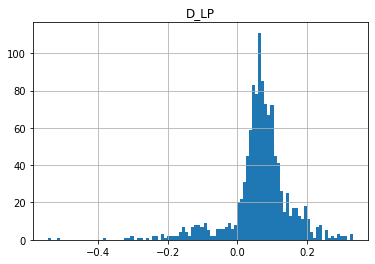

In [119]:
# histogram
final_data_collapsed.hist(column='D_LP', bins=100)
plt.show()
del review_data, business_data, zillow_data

# Models

In [121]:
# %% Create testing,training dataset

# define y-lp_cat and X-change in text feature vector, average stars. 

y_data = final_data_collapsed['D_LP_CAT']
X_data = final_data_collapsed[['D_stars']]

In [122]:
# split into training and test
X_train, X_test, y_train, y_test, X_words_train, X_words_test = train_test_split(
    X_data, y_data, X_words, test_size=0.25, random_state=1234)

In [ ]:
# Add in stars and yelp categories as features (text feature vector is numpy, X_train is df)
X_tr = hstack([X_words_train, np.matrix(X_train)])
X_te = hstack([X_words_test, np.matrix(X_test)])

vocab = vectorizer.get_feature_names()
vocab_str = [str(x.encode('utf-8')) for x in vocab]

# Tree Classifier

In [126]:
# Use the tree classifier
clf = DecisionTreeClassifier()
# clf = RandomForestClassifier(
#                n_estimators=128,
#                n_jobs=-1,
#                verbose=1)

# clf = DecisionTreeClassifier(max_leaf_nodes=15)

clf = clf.fit(X_tr, y_train)

In [130]:
if False:
    sum_words = X_tr.sum(axis=0) #sum up a words vector values across all the rows 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

    #Look a Top X frequent words
    for word, freq in words_freq[:10]:
       print(word, freq)  

Normalized confusion matrix
[[0.19 0.14 0.24 0.24 0.19]
 [0.14 0.18 0.15 0.23 0.29]
 [0.17 0.2  0.22 0.17 0.24]
 [0.22 0.2  0.27 0.2  0.12]
 [0.16 0.18 0.24 0.22 0.18]]


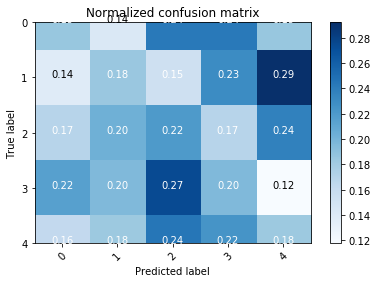

In [131]:
y_pred = clf.predict(X_te)

# confusion matrix
# create label
price_label = [0, 1, 2, 3, 4]
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
plot_confusion_matrix(cm, classes=price_label, normalize=True, title='Normalized confusion matrix')

Normalized confusion matrix
[[0.17 0.11 0.23 0.26 0.23]
 [0.12 0.22 0.18 0.22 0.26]
 [0.08 0.24 0.29 0.22 0.17]
 [0.16 0.14 0.31 0.29 0.1 ]
 [0.18 0.14 0.2  0.31 0.16]]
("b'great'", 0.0196391629607812)
("b'tomato'", 0.019500091184128546)
("b'good'", 0.019124995985751563)
('stars', 0.018267455127230704)
("b'going'", 0.017200727082956085)
("b'left'", 0.014876016552179178)
("b'order'", 0.014489254425424732)
("b'place'", 0.014279036036012232)
("b'services'", 0.014154411891822411)
("b'person'", 0.01296495756476091)
("b'love'", 0.012740981287377015)
("b'say'", 0.012475782091087708)
("b'just'", 0.012117578324629659)
("b'got'", 0.011825492591738002)
("b'nice'", 0.011547236205653245)
("b'restaurant'", 0.011318825643063775)
("b'new'", 0.011008688272251667)
("b'better'", 0.01066945325184032)
("b'time'", 0.010666634359152605)
("b'shop'", 0.009464804286834516)

the training_score is 1.0

the testing_score is 0.22448979591836735


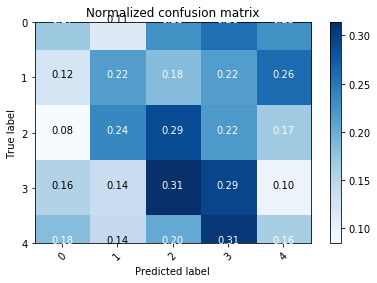

In [120]:
# features are the text labels, then STARS
feat_str = vocab_str + ["stars"]
dictionary = dict(zip(feat_str, clf.feature_importances_))
sorted_x = sorted(dictionary.items(), key=operator.itemgetter(1), reverse=True)
for x in range(20):
    print(sorted_x[x])

# overall score
training_score = clf.score(X_tr, y_train, sample_weight=None)
testing_score = clf.score(X_te, y_test, sample_weight=None)
print()
print("the training_score is " + str(training_score))
print()
print("the testing_score is " + str(testing_score))

# %%
# Graph the tree
# os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [ ]:
#export tree diagram
dot_data = StringIO()
tree.export_graphviz(clf, out_file=dot_data,
                     feature_names=feat_str,
                     filled=True, rounded=True, special_characters=True,
                     )

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graphfile = os.path.join(path, "fig", "graph_v2.pdf")
graph.write_pdf(graphfile)

# Naive Bayes

In [ ]:
# %%
# from sklearn.naive_bayes import MultinomialNB
#
# clf = MultinomialNB().fit(X_tr, y_train)  # classifying transformed text data to target value
#
# # confusion matrix
# y_pred = clf.predict(X_te)
# # cm=confusion_matrix(y_test, y_pred)
# # np.set_printoptions(precision=2)
# # plot_confusion_matrix(cm, classes=star_label,normalize=True,title='Normalized confusion matrix')
#
#
# # calculating the mean accuracy on the given test data and labels
# training_score = clf.score(X_tr, y_train, sample_weight=None)
# testing_score = clf.score(X_te, y_test, sample_weight=None)
# print()
# print("the training_score is " + str(training_score))
# print()
# print("the testing_score is " + str(testing_score))
#
# neg_class_prob_sorted = clf.feature_log_prob_[0, :].argsort()
# pos_class_prob_sorted = clf.feature_log_prob_[4, :].argsort()
#
# print(np.take(feat_str, neg_class_prob_sorted[-10:]))
# print(np.take(feat_str, pos_class_prob_sorted[-10:]))

# %%
# from sklearn.svm import LinearSVC
#
# clf = LinearSVC().fit(X_tr, y_train)  # classifying transformed text data to target value
#
# # confusion matrix
# y_pred = clf.predict(X_te)
# cm = confusion_matrix(y_test, y_pred)
# np.set_printoptions(precision=2)
# plot_confusion_matrix(cm, classes=price_label, normalize=True, title='Normalized confusion matrix')
#
# # calculating the mean accuracy on the given test data and labels
# training_score = clf.score(X_tr, y_train, sample_weight=None)
# testing_score = clf.score(X_te, y_test, sample_weight=None)
# print()
# print("the training_score is " + str(training_score))
# print()
# print("the testing_score is " + str(testing_score))
#
#
# def plot_coefficients(classifier, feature_names, top_features=10):
#     lowstar_coef = classifier.coef_[0, :] * -1
#     highstar_coef = classifier.coef_[4, :]
#     top_positive_coefficients = np.argsort(highstar_coef)[-top_features:]
#     top_negative_coefficients = np.argsort(lowstar_coef)[:top_features]
#     top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
#     # create plot
#     plt.figure(figsize=(15, 5))
#     colors = ['red' if c < 0 else 'blue' for c in
#               np.hstack([lowstar_coef[top_negative_coefficients], highstar_coef[top_positive_coefficients]])]
#     plt.bar(np.arange(2 * top_features),
#             np.hstack([lowstar_coef[top_negative_coefficients], highstar_coef[top_positive_coefficients]]),
#             color=colors)
#     feature_names = np.array(feature_names)
#     plt.xticks(np.arange(0, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60)
#     plt.show()
#
#
# plot_coefficients(clf, feat_str)
# # plot_coefficients(clf, vocab,star_type=4)

In [41]:
# %%
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)

clf = clf.fit(X_tr, y_train)

# calculating the mean accuracy on the given test data and labels
training_score = clf.score(X_tr, y_train, sample_weight=None)
testing_score = clf.score(X_te, y_test, sample_weight=None)
print()
print("the training_score is " + str(training_score))
print()
print("the testing_score is " + str(testing_score))

# %% Compare all the different types

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classifiers = [
    KNeighborsClassifier(3),
    LinearSVC(),
    # NuSVC(probability=True),
    # GaussianNB(),
    # MultinomialNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=8, n_jobs=-1, verbose=1),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
]

# Logging for Visual Comparison
log_cols = ["Classifier", "Accuracy"]
log = pd.DataFrame(columns=log_cols)

denseclass = ['GaussianNB', 'LinearDiscriminantAnalysis', 'QuadraticDiscriminantAnalysis']

for clf in classifiers:

    name = clf.__class__.__name__
    if name in denseclass:
        X_train = X_tr.toarray()
        X_test = X_te.toarray()
    else:
        X_train = X_tr
        X_test = X_te

    clf.fit(X_train, y_train)

    print("=" * 30)
    print(name)

    print('****Results****')
    acc = clf.score(X_test, y_test, sample_weight=None)
    print("Accuracy: {:.4%}".format(acc))

    log_entry = pd.DataFrame([[name, acc * 100]], columns=log_cols)
    log = log.append(log_entry)

print("=" * 30)

print(log.sort_values(by='Accuracy', ascending=False))


the training_score is 0.2108843537414966

the testing_score is 0.16666666666666666
KNeighborsClassifier
****Results****
Accuracy: 26.5306%
LinearSVC
****Results****
Accuracy: 15.6463%


//anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
//anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


LinearDiscriminantAnalysis
****Results****
Accuracy: 20.0680%
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 22.4490%
DecisionTreeClassifier
****Results****
Accuracy: 19.7279%
RandomForestClassifier
****Results****


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


Accuracy: 22.1088%
AdaBoostClassifier
****Results****
Accuracy: 20.0680%
GradientBoostingClassifier
****Results****
Accuracy: 24.8299%
                      Classifier   Accuracy
0           KNeighborsClassifier  26.530612
0     GradientBoostingClassifier  24.829932
0  QuadraticDiscriminantAnalysis  22.448980
0         RandomForestClassifier  22.108844
0     LinearDiscriminantAnalysis  20.068027
0             AdaBoostClassifier  20.068027
0         DecisionTreeClassifier  19.727891
0                      LinearSVC  15.646259
